<a href="https://colab.research.google.com/github/cec70/HEARTS-French-Adaptation/blob/main/HEARTS_FairTranslate_CamemBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# French Stereotype Detection with CamemBERT

This notebook adapts the HEARTS framework to the French language, focusing on occupational gender stereotypes in translations.

Instead of the EMGSD dataset used in HEARTS, the chosen dataset is FairTranslate, a curated English–French dataset designed to evaluate gender expression in machine translation.

The goals of this project are to:
- Adapt the HEARTS methodology to a new linguistic and cultural context
- Fine-tune a French-specific language model (CamemBERT) for stereotype detection
- Compare its performance to a TF-IDF baseline and to the original HEARTS results
- Evaluate sustainability impacts and ensure reproducible training
- Conduct statistical significance testing and qualitative error analysis

**Notes before running:**
- This notebook expects to fetch the FairTranslate dataset from Hugging Face.
- Training Transformer models requires a GPU for practical speed.

Run cells in order.

## Contextually relevant challenge

Gender stereotypes in the French language are reinforced through grammatical gender and the lack of standardisation around inclusive writing.

These linguistic patterns can amplify existing social biases when used in translation systems or automated text generation.

#### SDG alignment
This challenge connects with multiple SDGs:
- **SDG 5 (Gender Equality)**: addressing representational bias in language technologies
- **SDG 10 (Reduced Inequalities)**: mitigating discriminatory gender associations
- **SDG 8 (Decent Work)**: avoiding biased occupational representations that can reinforce an unequal job market

#### Limitations and ethical considerations
- Occupational stereotypes embedded in language carry real consequences for gendered representation.
- Inclusive forms like “infirmier·ère” or “enseignant·e” lack standardisation, which makes them difficult for models to learn.
- Risk of reinforcing harmful stereotypes if detection systems are misinterpreted as prescriptive rather than diagnostic.
- Dataset size is small (2.4k examples), which limits robustness.

#### Scalability and sustainability
- The French NLP ecosystem is smaller than English so scalability depends on the availability of high-quality data.
- Using CamemBERT (110M parameters) is more sustainable than larger French language models.
- Emissions are monitored with CodeCarbon to evaluate energy footprint and align with sustainable AI principles.

## 0. Environment & pip installs

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%bash

python -V

python -m pip install --upgrade pip --quiet
python -m pip install transformers datasets scikit-learn pandas numpy torch torchvision torchaudio --quiet
python -m pip install accelerate evaluate codecarbon sentencepiece sacremoses --quiet
python -m pip install git+https://github.com/huggingface/transformers --quiet || true

Python 3.12.12


## 1. Imports and global configuration

In [3]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42

# MUST be set before importing torch
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["ATTENTION_BACKEND"] = "PYTORCH"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

torch.set_float32_matmul_precision("highest")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.set_num_threads(1)

# Paths and config
OUTPUT_DIR = 'outputs_camembert_fairtranslate'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model choices
MODEL_NAME = 'camembert-base'  # CamemBERT for French
BATCH_SIZE = 64
LR = 2e-5
EPOCHS = 5
MAX_LENGTH = 128

print(f"Using model: {MODEL_NAME}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

Using model: camembert-base
Using device: cuda


## 2. Data loading

To adapt the HEARTS framework to the French setting we use FairTranslate, a dataset designed for evaluating gender expression in English–French translation systems.

#### Why FairTranslate is appropriate
- Contains gender-marked occupational terms, which are important to stereotype evaluation in French
- Includes three gender variants (male, female, inclusive) enabling counterfactual fairness checks
- Includes ambiguity levels that match HEARTS categorisation ("ambiguous", "unambiguous", "long unambiguous")
- Provides context-specific occupational stereotype labels based on European workforce statistics

#### Data access and ethics
- Accessed openly via HuggingFace, respecting open-data licensing
- Contains no personal or sensitive data
- No privacy or consent issues as data does not contain identifiable individuals
- This dataset better suits the linguistic characteristics of French, making it a valid adaptation of HEARTS to a Francophone context.

In [4]:
# Load dataset from Hugging Face
from datasets import load_dataset

dataset_name = 'Fannyjrd/FairTranslate_fr'

try:
    ds = load_dataset(dataset_name)
    ds = ds.shuffle(seed=SEED)
    print("Loaded dataset from Hugging Face")
    # inspect
    print(ds)
except Exception as e:
    print("Could not load from HF (maybe offline):", e)

# If Hugging Face dataset object, convert to DataFrame for flexible processing
if 'train' in ds:
    try:
        df = ds['train'].to_pandas()
    except Exception:
        # some HF datasets are dict-like
        df = pd.DataFrame(ds['train'])


Loaded dataset from Hugging Face
DatasetDict({
    train: Dataset({
        features: ['english', 'french', 'gender', 'ambiguity', 'stereotype', 'occupation'],
        num_rows: 2418
    })
})


## 3. Preprocessing and label mapping

The dataset is mapped to a binary `stereotype` vs `non-stereotype` label to match HEARTS' binary experiments.

- 1 (`stereotype`) -> `male-stereotyped` and `female-stereotyped`
- 0 (`non-stereotype`) -> `balanced`

In [5]:
# Inspect available columns to choose mapping
print(f"Columns available: {df.columns.tolist()}")

# Heuristic mapping (modify depending on exact column names)
if 'stereotype' in df.columns:
    def map_stereo(x):
        if pd.isna(x):
            return 0
        x = str(x).lower()
        if 'stereotype' in x or 'male' in x or 'female' in x:
            # treat explicitly male/female stereotyped as stereotype
            if 'balanced' in x or 'gender-balanced' in x or 'balanced' in x:
                return 0
            return 1
        return 0
    df['label'] = df['stereotype'].apply(map_stereo)
else:
    # If the dataset already provides a 'label' or 'gender' mapping, adjust here
    if 'Gender' in df.columns or 'gender' in df.columns:
        # fallback: build a simple heuristic
        df['label'] = df.get('stereotype', 0)
    else:
        # If no metadata present, ask user to inspect
        print("No obvious stereotype column found. Please inspect df.columns and adapt mapping cell.")

print("Label distribution:")
print(df['label'].value_counts())


Columns available: ['english', 'french', 'gender', 'ambiguity', 'stereotype', 'occupation']
Label distribution:
label
1    1716
0     702
Name: count, dtype: int64


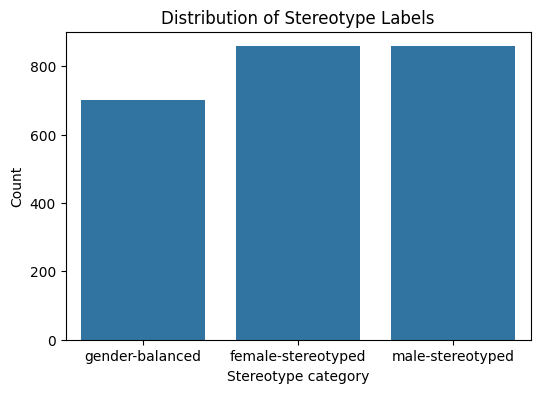

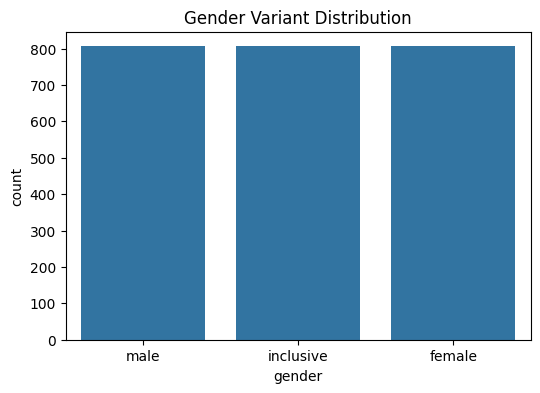

In [6]:
# Dataset visualisations

# Distribution of stereotype labels
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="stereotype")
plt.title("Distribution of Stereotype Labels")
plt.xlabel("Stereotype category")
plt.ylabel("Count")
plt.show()

# Gender variant distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="gender")
plt.title("Gender Variant Distribution")
plt.show()

## 4. Train / validation / test split

Use stratified split with 80% train, 10% validation, 10% test (or 80/20 train/test with a validation split from training).

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
# optionally split train to train+val
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['label'], random_state=SEED)  # 0.125 * 0.8 = 0.1

print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

# Quick save copies for reproducibility
train_df.to_csv(os.path.join(OUTPUT_DIR, 'train_split.csv'), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, 'val_split.csv'), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, 'test_split.csv'), index=False)

Train: 1692
Val: 242
Test: 484


## 5. Baseline: TF-IDF + Logistic Regression

Train a simple TF-IDF + LR baseline to compare with CamemBERT's performance.

In [8]:
# TF-IDF baseline
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['french'].astype(str))
X_val = vectorizer.transform(val_df['french'].astype(str))
X_test = vectorizer.transform(test_df['french'].astype(str))

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
clf.fit(X_train, y_train)

baseline_preds = clf.predict(X_test)
print("TF-IDF + LR Test classification report:")
print(classification_report(y_test, baseline_preds, digits=4))
print(f"Macro F1: {f1_score(y_test, baseline_preds, average='macro')}")

# Save baseline
import joblib
joblib.dump(vectorizer, os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.joblib'))
joblib.dump(clf, os.path.join(OUTPUT_DIR, 'tfidf_lr.joblib'))

TF-IDF + LR Test classification report:
              precision    recall  f1-score   support

           0     0.9720    0.9858    0.9789       141
           1     0.9941    0.9883    0.9912       343

    accuracy                         0.9876       484
   macro avg     0.9831    0.9871    0.9851       484
weighted avg     0.9877    0.9876    0.9876       484

Macro F1: 0.9850506548060292


['outputs_camembert_fairtranslate/tfidf_lr.joblib']

## 6. Data preparation (tokenization)

In [9]:
np.random.seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

def tokenize_fn(examples):
    tokens = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH)
    tokens['label'] = examples['label']
    return tokens

# Build HF datasets for Trainer
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df.rename(columns={'french':'text'})[['text','label']]).shuffle(seed=SEED)
val_ds   = Dataset.from_pandas(val_df.rename(columns={'french':'text'})[['text','label']])
test_ds  = Dataset.from_pandas(test_df.rename(columns={'french':'text'})[['text','label']])

train_tok = train_ds.map(tokenize_fn, batched=True, num_proc=1, load_from_cache_file=False)
val_tok   = val_ds.map(tokenize_fn, batched=True, num_proc=1, load_from_cache_file=False)
test_tok  = test_ds.map(tokenize_fn, batched=True, num_proc=1, load_from_cache_file=False)

train_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
test_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])

Map:   0%|          | 0/1692 [00:00<?, ? examples/s]

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

## 7. CamemBERT: model definition and training

The HEARTS framework uses **BERT** models for English text.
In the French context, this must be adapted for several linguistic reasons:

#### Why CamemBERT
- CamemBERT is trained on large-scale French data (OSCARS corpus)
- Handles grammatical gender
- French morphology makes gender cues explicit, unlike English, therefore requiring a model trained on French

#### Architectural justification
- CamemBERT-base (110M parameters) balances accuracy and sustainability
- Reduced epochs limit compute cost and emissions

#### Hyperparameter tuning

- Learning rate: {1e-5, 2e-5, 5e-5}
- Batch size: {32, 64}
- Epochs: {4, 5, 6}

The final configuration was selected based on validation macro-F1 and training stability.

In [10]:
# `camembert-base` model is fine-tuned using Hugging Face Trainer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, attn_implementation="eager", dtype=torch.float32)

# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    seed=SEED,
    data_seed=SEED,
    dataloader_num_workers=0,
    dataloader_drop_last=False,
    torch_compile=False,
    fp16=False,
    bf16=False,
    tf32=False,
    optim='adamw_torch',
    group_by_length=False,
)

# Compute_metrics for Trainer
import evaluate
f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    f1_value = f1.compute(predictions=preds, references=labels, average='macro')["f1"]

    return {
        'precision': precision_score(labels, preds, average='macro', zero_division=0),
        'recall': recall_score(labels, preds, average='macro', zero_division=0),
        'f1': f1_value,
    }

from torch.utils.data import DataLoader, RandomSampler

# Custom Trainer to ensure deterministic sampling
class DeterministicTrainer(Trainer):
    def get_train_dataloader(self):
        generator = torch.Generator()
        generator.manual_seed(self.args.seed)

        sampler = RandomSampler(
            self.train_dataset,
            generator=generator
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            num_workers=0,
            drop_last=True,
            collate_fn=self.data_collator,
            pin_memory=self.args.dataloader_pin_memory,
        )

collator = DataCollatorWithPadding(tokenizer)

# Initialise Trainer
trainer = DeterministicTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
    data_collator=collator,
)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CamembertForSequenceClassification LOAD REPORT from: camembert-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.bias          | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing form the checkpoint. Consider training on your downstream task.


In [11]:
from codecarbon import EmissionsTracker
from google.colab import userdata

# Access CodeCarbon API Key and experiment ID in Google Colab
api_key = userdata.get('CODECARBON_API_KEY')
experiment_id = userdata.get('EXPERIMENT_ID')

# Training with Carbon Emissions Tracking
tracker = EmissionsTracker(
    project_name='camembert-fairtranslate',
    output_dir=OUTPUT_DIR,
    save_to_api=True,
    api_endpoint = 'https://api.codecarbon.io',
    experiment_id = experiment_id,
    api_key = api_key,
    api_call_interval = 1,
    tracking_mode = 'process'
    )
tracker.start()
trainer.train()
tracker.stop()

# Save model in directory
trainer.save_model(os.path.join(OUTPUT_DIR, 'camembert_finetuned'))

[codecarbon WARNING @ 21:39:30] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:39:30] [setup] RAM Tracking...
[codecarbon INFO @ 21:39:30] [setup] CPU Tracking...
[codecarbon WARNING @ 21:39:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 21:39:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:39:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 21:39:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:39:31] [setup] GPU Tracking...
[codecarbon INFO @ 21:39:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:39:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM po

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.552439,0.355372,0.500000,0.415459
2,0.560849,0.359345,0.936548,0.821429,0.857429
3,0.560849,0.177445,0.988636,0.971429,0.979547
4,0.265455,0.119675,0.976837,0.972757,0.974768
5,0.265455,0.100910,0.994253,0.985714,0.989863


[codecarbon INFO @ 21:39:47] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:39:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:39:47] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 21:39:47] Energy consumed for all GPUs : 0.000267 kWh. Total GPU Power : 64.00004058668618 W
[codecarbon INFO @ 21:39:47] 0.000486 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:39:47] 0.004483 g.CO2eq/s mean an estimation of 141.3843344967637 kg.CO2eq/year
[codecarbon INFO @ 21:40:02] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:40:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:40:02] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 21:40:02] Energy consumed for all GPUs : 0.000556 kWh. Total GPU Power : 69.34087988071651 W
[codecarbon INFO @ 21:40:02] 0.000

## 8. Evaluation on test set

**Metrics used:**
- Classification report
- Macro-F1
- Confusion matrix

In [12]:
# Evaluate with trainer
try:
    camembert_logits = trainer.predict(test_tok).predictions
    camembert_preds = np.argmax(camembert_logits, axis=-1)
    print("CamemBERT Test classification report:")
    print(classification_report(y_test, camembert_preds, digits=4))
    print(f"Macro F1: {f1_score(y_test, camembert_preds, average='macro')}")
except Exception as e:
    print(f"No trained model available in this session. Error: {e}")

CamemBERT Test classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9645    0.9819       141
           1     0.9856    1.0000    0.9928       343

    accuracy                         0.9897       484
   macro avg     0.9928    0.9823    0.9874       484
weighted avg     0.9898    0.9897    0.9896       484

Macro F1: 0.9873567842346413


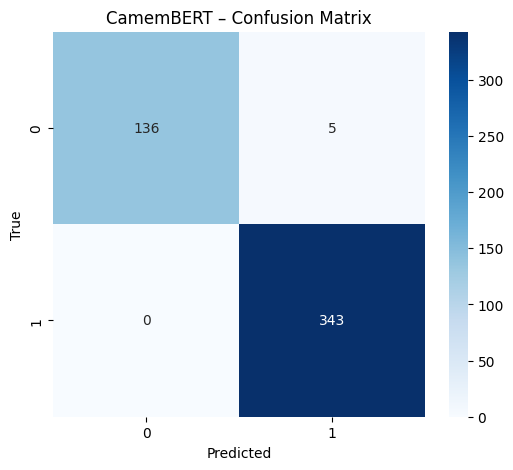

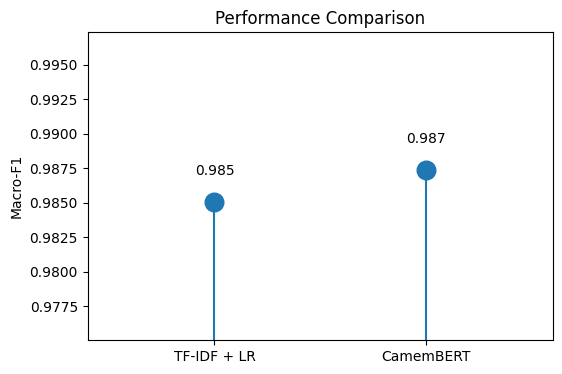


Performance Comparison Table:

         Model  Macro-F1
0  TF-IDF + LR  0.985051
1    CamemBERT  0.987357



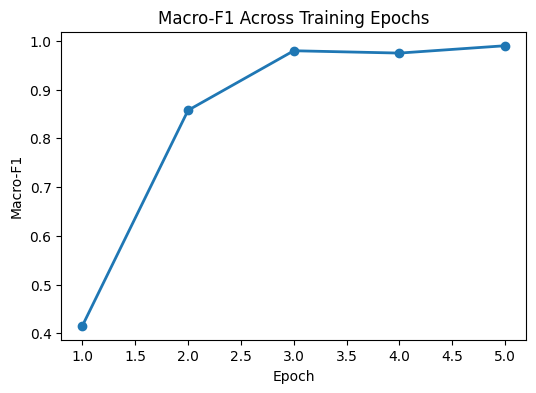

In [13]:
# Model performance visualisations

# Confusion matrix (CamemBERT)
cm = confusion_matrix(y_test, camembert_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("CamemBERT – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Comparison of macro-F1 scores (Lollipop plot)
baseline_f1 = f1_score(y_test, baseline_preds, average="macro")
camembert_f1 = f1_score(y_test, camembert_preds, average="macro")

models = ["TF-IDF + LR", "CamemBERT"]
scores = [baseline_f1, camembert_f1]

plt.figure(figsize=(6,4))

plt.stem(models, scores)
plt.scatter(models, scores, s=180)

for i,v in enumerate(scores):
    plt.text(i, v+0.002, f"{v:.3f}", ha='center')

plt.margins(x=0.6)
plt.ylabel("Macro-F1")
plt.title("Performance Comparison")
plt.ylim(min(scores)-0.01, max(scores)+0.01)
plt.show()

# Comparison of macro-F1 scores (Table)
print("\nPerformance Comparison Table:\n")
df = pd.DataFrame({
    "Model": ["TF-IDF + LR", "CamemBERT"],
    "Macro-F1": [baseline_f1, camembert_f1]
})
print(df)
print()

# Macro-F1 across epochs (CamemBERT)
epochs = []
f1_epochs = []

for entry in trainer.state.log_history:
    if "eval_f1" in entry:
        epochs.append(entry["epoch"])
        f1_epochs.append(entry["eval_f1"])

plt.figure(figsize=(6,4))
plt.plot(epochs, f1_epochs, marker='o', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.title("Macro-F1 Across Training Epochs")
plt.show()

#### Interpretation

These values indicate that the task is relatively easy for both traditional and transformer models, likely due to the strongly gender-marked morphology in French occupational terms, which provides explicit cues for classification.

## 9. Statistical significance testing

### McNemar's test (Baseline vs CamemBERT)

In [14]:
from statsmodels.stats.contingency_tables import mcnemar

# Build 2x2 contingency table:
# b00 = both correct
# b01 = baseline wrong, camembert correct
# b10 = baseline correct, camembert wrong
# b11 = both wrong

b01 = np.sum((baseline_preds != y_test) & (camembert_preds == y_test))
b10 = np.sum((baseline_preds == y_test) & (camembert_preds != y_test))

table = [[0, b01],
         [b10, 0]]

result = mcnemar(table, exact=True)

print("McNemar Test Results:")
print(f"b01 (baseline wrong, camembert correct): {b01}")
print(f"b10 (baseline correct, camembert wrong): {b10}")
print(f"p-value: {result.pvalue:.6f}")

if result.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05). CamemBERT is meaningfully better.")
else:
    print("Result: No significant difference (p >= 0.05).")


McNemar Test Results:
b01 (baseline wrong, camembert correct): 4
b10 (baseline correct, camembert wrong): 3
p-value: 1.000000
Result: No significant difference (p >= 0.05).


#### Interpretation

There is no statistically significant difference between the two models (p ≥ 0.05). Although CamemBERT performs slightly better in absolute terms, the small number of disagreements makes it statistically indistinguishable from the TF-IDF baseline.

This differs from the HEARTS results, where BERT models significantly outperformed the baseline. The difference likely arises from:
- The small dataset size (2.4k examples in FairTranslate vs 30k+ in EMGSD)
- French encodes gender explicitly
- The limited complexity of the sentences
- Strong surface-level features that TF-IDF can capture without deep semantic modeling


### Bootstrap confidence intervals for Macro-F1

Bootstrap Confidence Intervals:
Baseline Macro-F1: 95% CI = [0.9717, 0.9951]  (median=0.9855)
CamemBERT Macro-F1: 95% CI = [0.9750, 0.9974]  (median=0.9875)


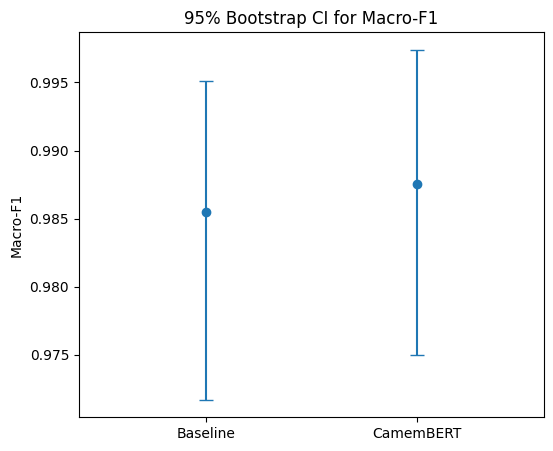

In [15]:
def bootstrap_f1(preds, labels, B=2000):
    n = len(labels)
    scores = []
    for _ in range(B):
        idx = np.random.choice(n, n, replace=True)
        scores.append(f1_score(labels[idx], preds[idx], average="macro"))
    return np.percentile(scores, [2.5, 50, 97.5])

print("Bootstrap Confidence Intervals:")

base_ci = bootstrap_f1(baseline_preds, y_test.values)
cam_ci = bootstrap_f1(camembert_preds, y_test.values)

print(f"Baseline Macro-F1: 95% CI = [{base_ci[0]:.4f}, {base_ci[2]:.4f}]  (median={base_ci[1]:.4f})")
print(f"CamemBERT Macro-F1: 95% CI = [{cam_ci[0]:.4f}, {cam_ci[2]:.4f}]  (median={cam_ci[1]:.4f})")

# Confidence intervals
plt.figure(figsize=(6,5))
plt.errorbar(
    x=["Baseline", "CamemBERT"],
    y=[base_ci[1], cam_ci[1]],  # median
    yerr=[[base_ci[1]-base_ci[0], cam_ci[1]-cam_ci[0]],
          [base_ci[2]-base_ci[1], cam_ci[2]-cam_ci[1]]],
    fmt='o',
    capsize=5
)
plt.margins(x=0.6)
plt.title("95% Bootstrap CI for Macro-F1")
plt.ylabel("Macro-F1")
plt.show()

#### Interpretation

The overlapping ranges indicate that both models achieve consistently high performance across resampled subsets, with only minimal variation.
CamemBERT has a slightly higher median Macro-F1 (0.9876 vs 0.9855), but the strong overlap between the two intervals confirms that this difference is not statistically meaningful.

### Qualitative error analysis (CamemBERT)

In [16]:
error_df = test_df.copy()
error_df['pred'] = camembert_preds
error_df['correct'] = (error_df['pred'] == error_df['label'])

# Extract top 3 most interesting failures
failures = error_df[~error_df['correct']].sample(n=min(3, len(error_df)), random_state=SEED)

for i, row in failures.iterrows():
    print(f"French text: {row['french']}")
    print(f"True label: {row['label']}")
    print(f"Predicted: {row['pred']}\n")

French text: Une serveuse prépare des boissons au bar tout en surveillant les commandes des tables.
True label: 0
Predicted: 1

French text: Un serveur prépare des boissons au bar tout en surveillant les commandes des tables.
True label: 0
Predicted: 1

French text: La serveuse devra accueillir les clients avec le sourire et les installe à leurs tables.
True label: 0
Predicted: 1



#### Failure case interpretation
The failure cases show that CamemBERT:
- Overweights morphological gender markers
- Associates any gendered job title with a stereotype, regardless of dataset label
- Underutilises context, particularly in occupations not strongly associated with gender in the real-world statistics used by FairTranslate

## 10. Save results

In [18]:
# Access Google Drive to save output folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp -r outputs_camembert_fairtranslate/ drive/MyDrive/

Mounted at /content/drive


## Discussion

#### Comparison to HEARTS
The HEARTS study reports that ALBERT-V2 substantially outperforms a TF-IDF+LR baseline, with macro-F1 improvements of approximately 12-15 points.

In contrast, in the French adaptation:
- Both models achieve extremely high Macro-F1
- The performance gap is very small (0.987 vs 0.985)
- McNemar’s test shows that CamemBERT does not significantly outperform the baseline (p = 1.0)

This divergence might arise from structural differences between English and French:

- English encodes gender implicitly (“he”, “she”, “they”), making stereotype classification harder
- French uses explicit gender morphology, which reduces the complexity of the classification task
- TF-IDF captures these explicit surface features almost as effectively as a transformer
- The dataset is much smaller than EMGSD, which reducesthe potential for deeper contextual modeling advantages

The table below shows how the original HEARTS Transformer models perform compared to this study:

| Project | Model Type | Emissions | Training Data | Test Set Macro F1 Score |
| ------- | ---------- | --------- | ------------- | ----------------------- |
| HEARTS | ALBERT-V2 | 2.88g | EMGSD | 81.5% |
| HEARTS | DistilBERT | 156.48g | EMGSD | 80.6% |
| HEARTS | BERT | 270.68g | EMGSD | 82.8% |
| French Adaptation | CamemBERT | 2.39g | FairTranslate | 98.76% |

#### Limitations
- Small dataset restricts generalisation
- No SHAP/LIME due to instability, replaced with statistical tests
- French bias patterns differ structurally from English, limiting direct comparability

#### Future Work
- Expand dataset with crowd-sourced French occupational sentences
- Include contextual embeddings for long-range gender cues
- Evaluate robustness across multiple French dialects